<a href="https://colab.research.google.com/github/salaheddinos/Personal_Projects/blob/main/Bankruptcy_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# Import necessary libraries
import numpy as np
from numpy import median
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from scipy import stats
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import f1_score, confusion_matrix, classification_report, recall_score, precision_score, plot_precision_recall_curve
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

## Introduction

In this notebook, we're going to predict companies that go bankrupt. I'm new here on Kaggle and I'd really like an upvote from your part if you liked this work, this will really encourage me to keep doing projects like that. Also if you have any suggestions or remarks please let me know on the comment section. Thanks ! 

Dataset description provided: "The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange."

In [2]:
# Ignore warnings
warnings.filterwarnings("ignore") 
# Import data
data = pd.read_csv('bank.csv')

In [3]:
# Inspect data
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

In [4]:
# Create copy of df
df = data.copy()
# Check Missing data
df.isnull().sum().any()

False

The data contains no missing values. 

In [ ]:
# Shape of df
print("Number of rows : {}".format(df.shape[0]), '\n'
      "Number of cols : {}".format(df.shape[1]))

Number of rows : 6819 
Number of cols : 96


## A) Recursive Feature Elimination with Cross-validation (RFECV):




This data has a large number of features. In order to make the EDA easier and improve the accuracy of machine learning models, we need to reduce the dimensionality of the data. For this purpose, I'm going to use a famous feature selection method named Recursive Feature Elimination. Recursive feature elimination is an example of backward feature elimination in which we essentially first fit our model using all the features in a given set, then progressively one by one we remove the least significant features, each time re-fitting, until we are left with the desired number of features

In [5]:
# Set X and y 
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
# Set training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Optimal number of features : 32


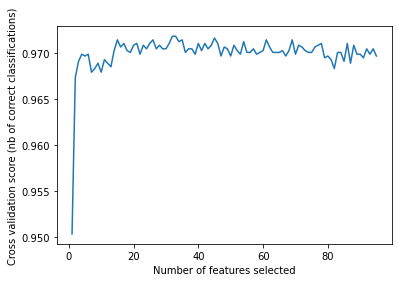

In [6]:
# Set RandomForestClassifier as estimator for RFECV
cart = RandomForestClassifier(random_state=42)
# Minimum number of features to consider
min_features_to_select = 1  
# Set number of folds
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1) 
# Set cross-validation process
rfecv = RFECV(estimator=cart, step=1, cv=cv,
              scoring='accuracy',
              min_features_to_select=min_features_to_select, n_jobs=1)
# Fit the model
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [7]:
# Display features' names
most_relevent_cols = df.iloc[:, 1:].columns[np.where(rfecv.support_ == True)]
print("Most relevant features are: ")
print(most_relevent_cols)

Most relevant features are: 
Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' Non-industry income and expenditure/revenue',
       ' Interest-bearing debt interest rate', ' Net Value Per Share (B)',
       ' Net Value Per Share (A)', ' Net Value Per Share (C)',
       ' Persistent EPS in the Last Four Seasons',
       ' Per Share Net profit before tax (Yuan ¥)', ' Net Value Growth Rate',
       ' Total Asset Return Growth Rate Ratio', ' Quick Ratio',
       ' Interest Expense Ratio', ' Total debt/Total net worth',
       ' Net worth/Assets', ' Borrowing dependency',
       ' Net profit before tax/Paid-in capital',
       ' Accounts Receivable Turnover', ' Inventory Turnover Rate (times)',
       ' Fixed Assets Turnover Frequency', ' Allocation rate per person',
       ' Cash/Total Assets', ' Cash/Current Liability',
       ' Inventory/Working Capital', ' Working Capital/Equity',
       ' Net Income to Total As

In [8]:
# Append target
most_relevent_cols = list(most_relevent_cols)
most_relevent_cols.append("Bankrupt?")

In [9]:
# Display df
rfecv_df = df[most_relevent_cols]
rfecv_df.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,Non-industry income and expenditure/revenue,Interest-bearing debt interest rate,Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Net worth/Assets,Borrowing dependency,Net profit before tax/Paid-in capital,Accounts Receivable Turnover,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Allocation rate per person,Cash/Total Assets,Cash/Current Liability,Inventory/Working Capital,Working Capital/Equity,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
0,0.370594,0.424389,0.302646,0.000725,0.147950,0.147950,0.147950,0.169141,0.138736,0.000327,0.263100,0.001208,0.629951,0.021266,0.792424,0.390284,0.137757,0.001814,1.820926e-04,1.165007e-04,0.037135,0.004094,1.473360e-04,0.276920,0.721275,0.716845,0.009219,0.622879,0.827890,0.026601,0.564050,0.016469,1
1,0.464291,0.538214,0.303556,0.000647,0.182251,0.182251,0.182251,0.208944,0.169918,0.000443,0.264516,0.004039,0.635172,0.012502,0.828824,0.376760,0.168962,0.001286,9.360000e+09,7.190000e+08,0.012335,0.014948,1.383910e-03,0.289642,0.731975,0.795297,0.008323,0.623652,0.839969,0.264577,0.570175,0.020794,1
2,0.426071,0.499019,0.302035,0.000790,0.177911,0.177911,0.193713,0.180581,0.142803,0.000396,0.264184,0.005348,0.629631,0.021248,0.792484,0.379093,0.148036,0.001495,6.500000e+07,2.650000e+09,0.141016,0.000991,5.340000e+09,0.277456,0.742729,0.774670,0.040003,0.623841,0.836774,0.026555,0.563706,0.016474,1
3,0.399844,0.451265,0.303350,0.000449,0.154187,0.154187,0.154187,0.193722,0.148603,0.000382,0.263371,0.002896,0.630228,0.009572,0.848535,0.379743,0.147561,0.001966,7.130000e+09,9.150000e+09,0.021320,0.018851,1.010646e-03,0.276580,0.729825,0.739555,0.003252,0.622929,0.834697,0.026697,0.564663,0.023982,1
4,0.465022,0.538432,0.303475,0.000686,0.167502,0.167502,0.167502,0.212537,0.168412,0.000439,0.265218,0.003727,0.636055,0.005150,0.893491,0.375025,0.167461,0.001449,1.633674e-04,2.935211e-04,0.023988,0.014161,6.804636e-04,0.287913,0.732000,0.795016,0.003878,0.623521,0.839973,0.024752,0.575617,0.035490,1


## B) EDA

In this part, I'm going to do some Exploratory Data Analysis on the features previously selected by RFECV. Understanding our features is key for building more accurate machine learning models.

### a) Descriptive statistics

In [11]:
# Descriptive stats
rfecv_df.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,Non-industry income and expenditure/revenue,Interest-bearing debt interest rate,Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Net worth/Assets,Borrowing dependency,Net profit before tax/Paid-in capital,Accounts Receivable Turnover,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Allocation rate per person,Cash/Total Assets,Cash/Current Liability,Inventory/Working Capital,Working Capital/Equity,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
count,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.505180,0.558625,0.303623,1.644801e+07,0.190661,0.190633,0.190672,0.228813,0.184361,1.566212e+06,0.264248,8.376595e+06,0.630991,4.416337e+06,0.886823,0.374654,0.182715,1.278971e+07,2.149106e+09,1.008596e+09,1.125579e+07,0.124095,3.715999e+07,0.277395,0.735817,0.807760,1.862942e+07,0.623915,0.840402,0.027541,0.565358,0.047578,0.032263
std,0.060686,0.065620,0.011163,1.082750e+08,0.033390,0.033474,0.033480,0.033263,0.033180,1.141594e+08,0.009634,2.446847e+08,0.011238,1.684069e+08,0.053920,0.016286,0.030785,2.782598e+08,3.247967e+09,2.477557e+09,2.945063e+08,0.139251,5.103509e+08,0.010469,0.011678,0.040332,3.764501e+08,0.012290,0.014523,0.015668,0.013214,0.050014,0.176710
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.476527,0.535543,0.303466,2.030203e-04,0.173613,0.173613,0.173676,0.214711,0.170370,4.409689e-04,0.263759,4.725903e-03,0.630612,3.007049e-03,0.851196,0.370168,0.169376,7.101336e-04,1.728256e-04,2.330013e-04,4.120529e-03,0.033543,1.973008e-03,0.277034,0.733612,0.796750,9.036205e-04,0.623636,0.840115,0.026791,0.565158,0.024477,0.000000
50%,0.502706,0.559802,0.303525,3.210321e-04,0.184400,0.184400,0.184400,0.224544,0.179709,4.619555e-04,0.264050,7.412472e-03,0.630698,5.546284e-03,0.888593,0.372624,0.178456,9.678107e-04,7.646743e-04,5.930942e-04,7.844373e-03,0.074887,4.903886e-03,0.277178,0.736013,0.810619,2.085213e-03,0.623879,0.841179,0.026808,0.565252,0.033798,0.000000
75%,0.535563,0.589157,0.303585,5.325533e-04,0.199570,0.199570,0.199612,0.238820,0.193493,4.993621e-04,0.264388,1.224911e-02,0.631125,9.273293e-03,0.927109,0.376271,0.191607,1.454759e-03,4.620000e+09,3.652371e-03,1.502031e-02,0.161073,1.280557e-02,0.277429,0.738560,0.826455,5.269777e-03,0.624168,0.842357,0.026913,0.565725,0.052838,0.000000
max,1.000000,1.000000,1.000000,9.900000e+08,1.000000,1.000000,1.000000,1.000000,1.000000,9.330000e+09,1.000000,9.230000e+09,1.000000,9.940000e+09,1.000000,1.000000,1.000000,9.740000e+09,9.990000e+09,9.990000e+09,9.570000e+09,1.000000,9.650000e+09,1.000000,1.000000,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Most of the values in the data range between 0 and 1. But we can see that there are some extreme values (outliers). 

% of Data
0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64
Count
0    6599
1     220
Name: Bankrupt?, dtype: int64


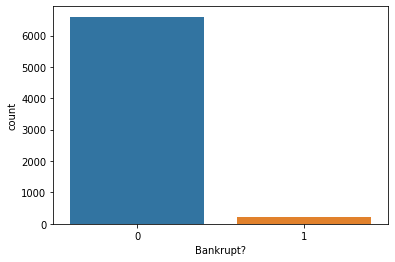

In [ ]:
# Analyse target var
sns.countplot(rfecv_df['Bankrupt?'])
# Target 
print("% of Data") 
print(df['Bankrupt?'].value_counts(normalize=True))
print("Count")
print(df['Bankrupt?'].value_counts())

We can observe that our dataset is very imbalanced. The minority class which is the one we're most interested by predicting represents about 3% of total observations. This can pose a real challenge to machine learning models.

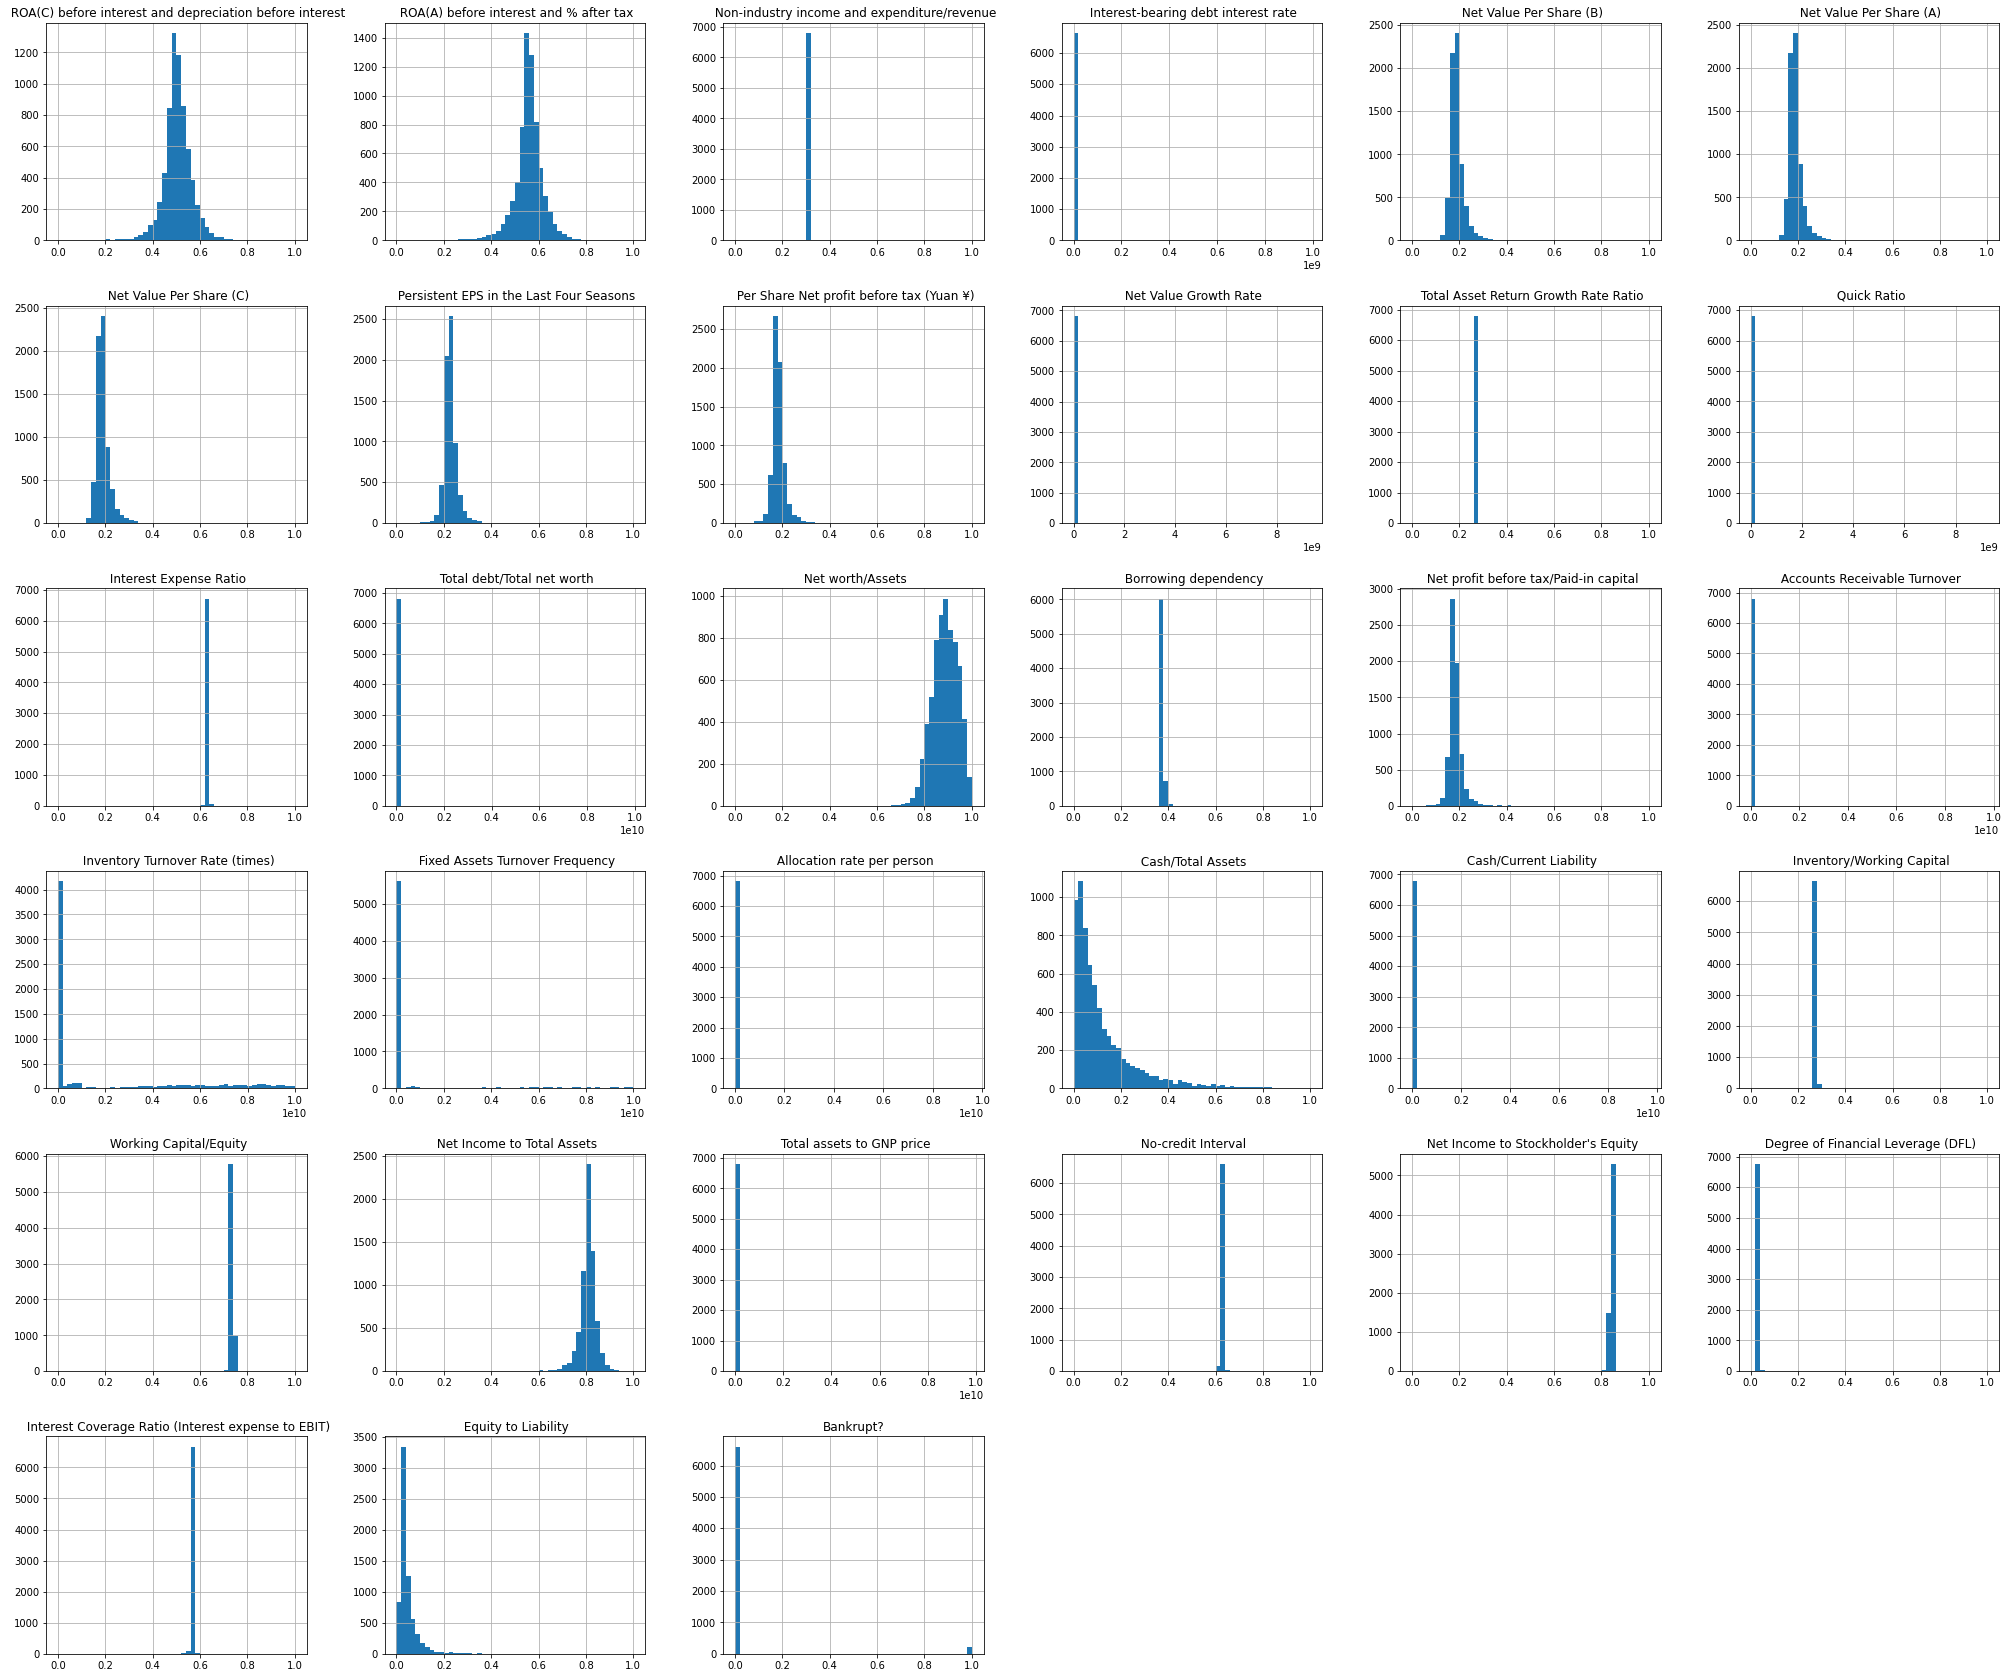

In [ ]:
# Looking at the histograms of numerical data
rfecv_df.hist(figsize = (35,30), bins = 50)
plt.show()

We can see that most features don't follow a normal distribution and many of them have very skwed distribution. This might be solved by applying a log transformation but as you'll see later in the notebook, I'll chose to simply replace extreme positive values with the median of the target group. 

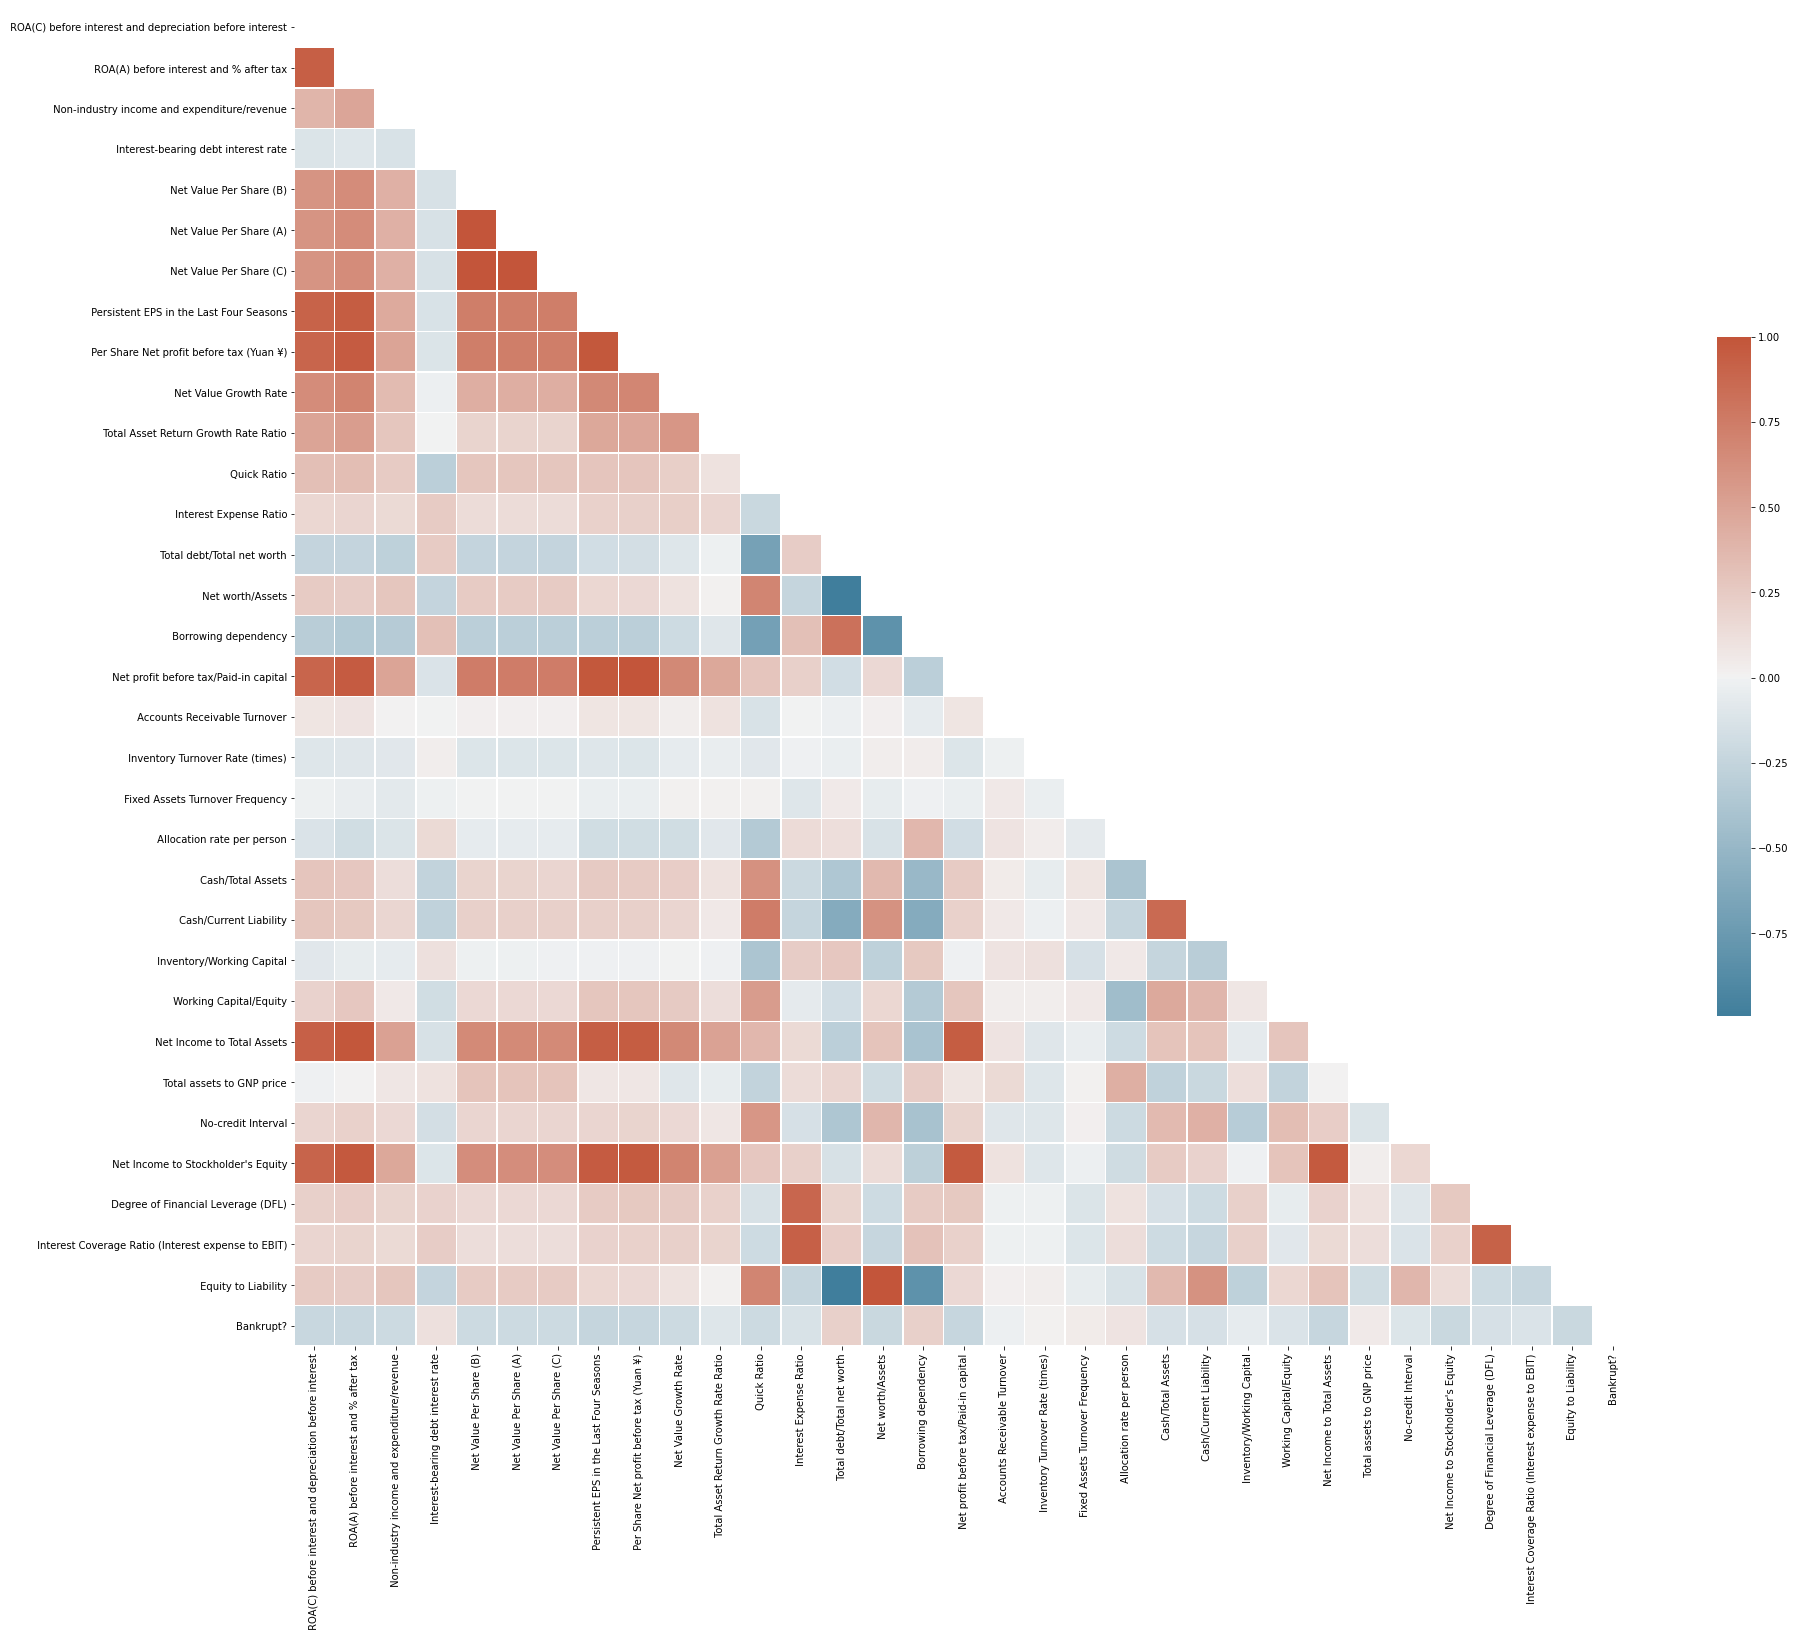

In [ ]:
# Correlations
rfecv_df.corr('spearman')["Bankrupt?"].sort_values() 
# Correlation Heatmap (Spearman)
f, ax = plt.subplots(figsize=(30, 25))
mat = rfecv_df.corr('spearman')  
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### b) Analysis of variance and hypothesis testing

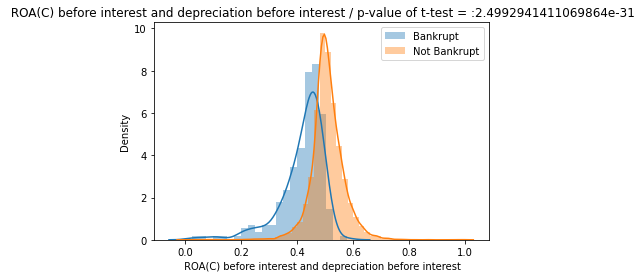

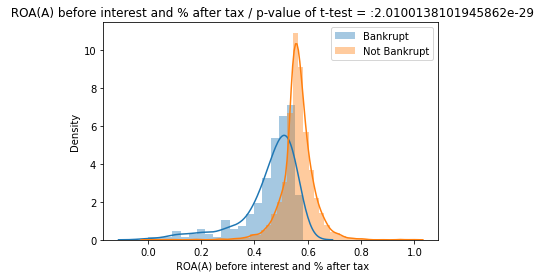

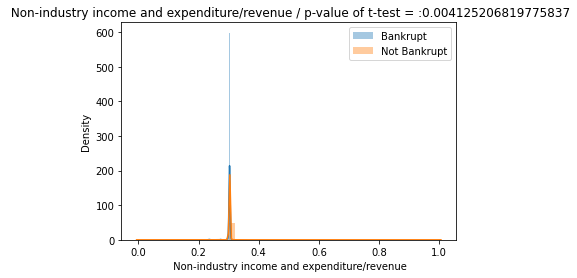

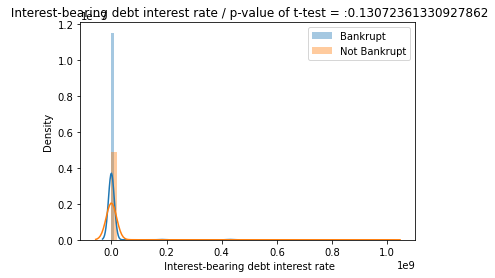

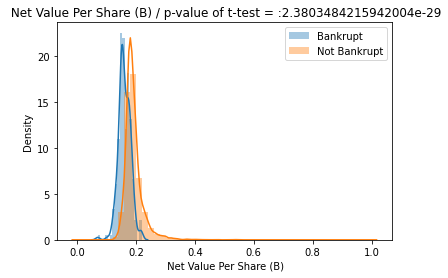

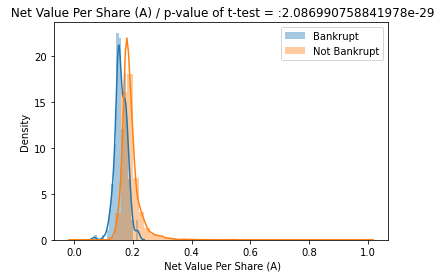

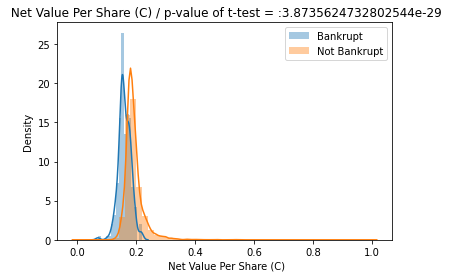

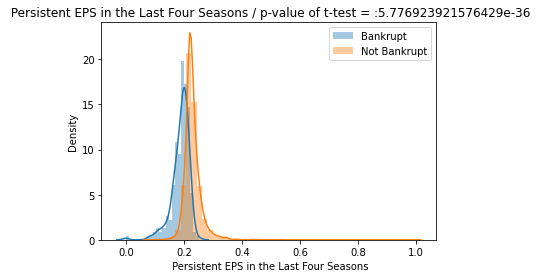

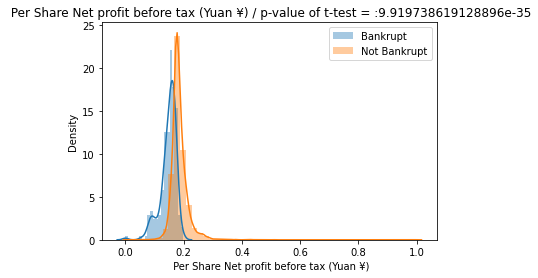

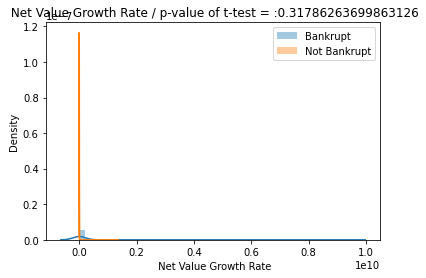

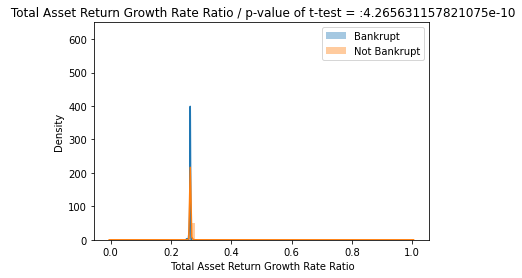

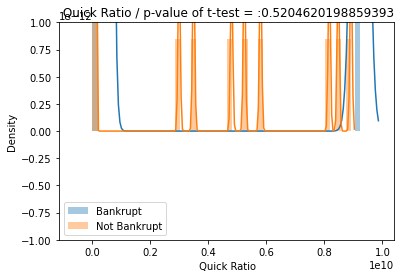

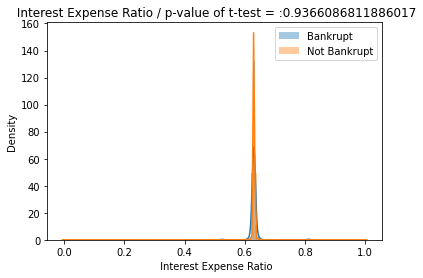

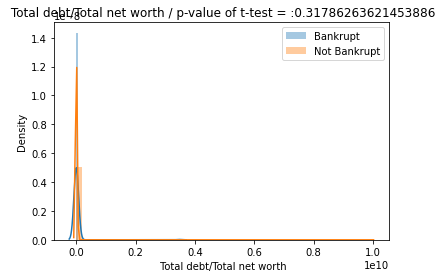

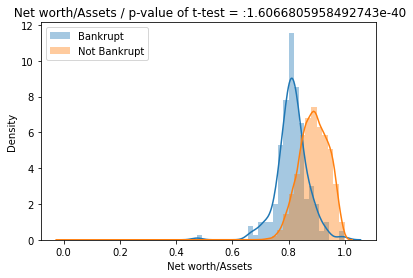

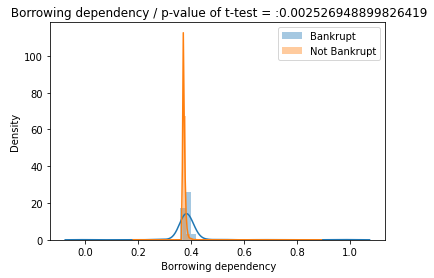

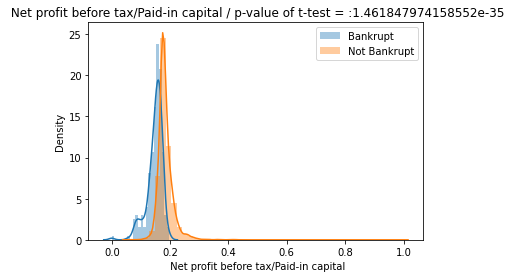

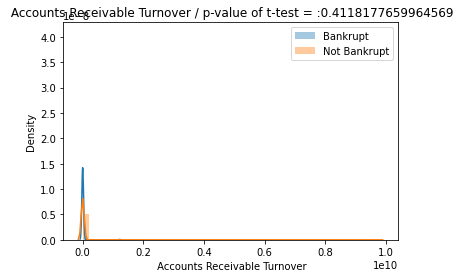

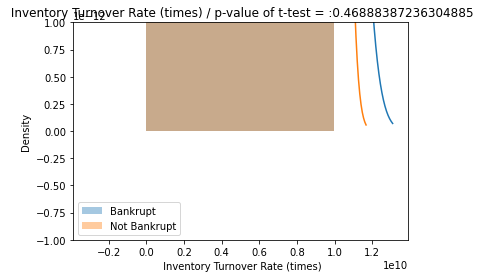

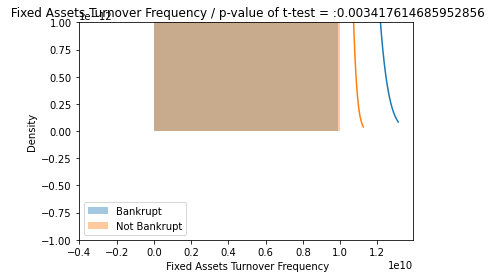

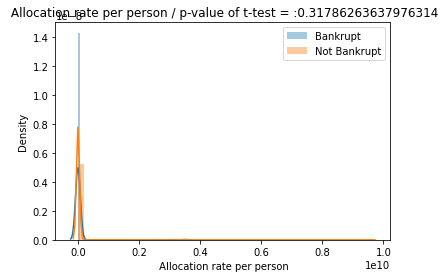

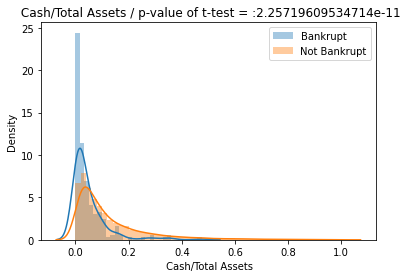

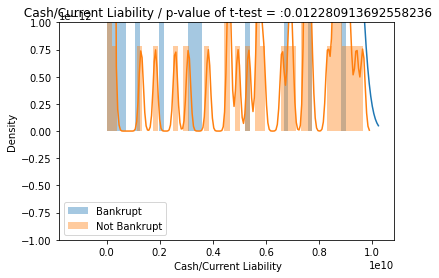

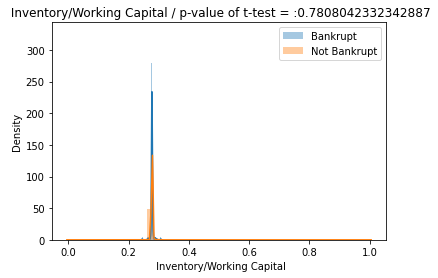

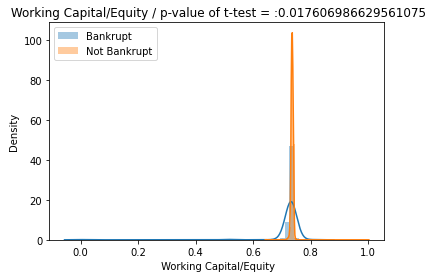

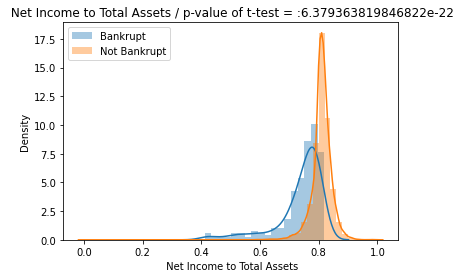

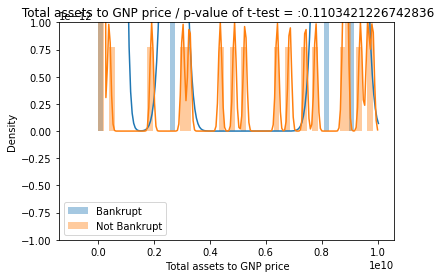

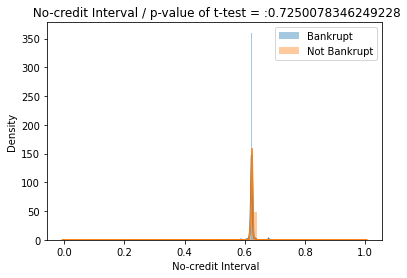

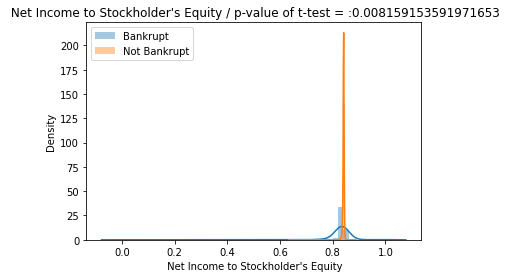

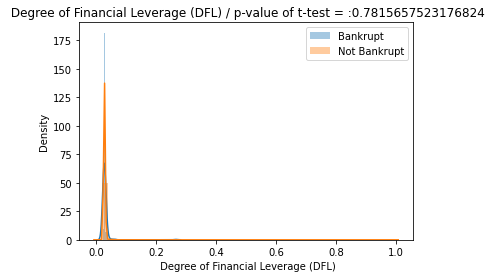

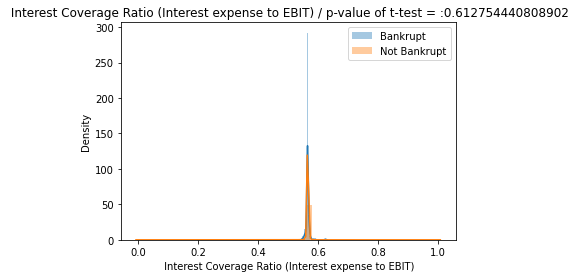

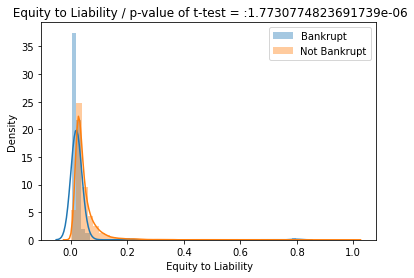

In [12]:
# Seperate dfs
bankrupt_df = rfecv_df[rfecv_df['Bankrupt?']==True]
not_bankrupt_df = rfecv_df[rfecv_df['Bankrupt?']==False]

# Analyze distributions of selected features using rfecv
cols = rfecv_df.drop("Bankrupt?", axis=1).columns

for feature in cols:
  a = bankrupt_df[feature]
  b = not_bankrupt_df[feature]
  b = b.sample(n=len(a), random_state=42) # Take random sample from each feature to match length of target
  # Running t-tests
  test = stats.ttest_ind(a,b)   
  plt.figure() 
  sns.distplot(bankrupt_df[feature], kde=True, label="Bankrupt")
  sns.distplot(not_bankrupt_df[feature], kde=True, label="Not Bankrupt") 
  plt.title("{} / p-value of t-test = :{}".format(feature, test[1]))
  plt.legend()

### **Conclusions:** 
The following are some features that significantly differentiate the two groups of our target. The definitions of these indicators were all taken from Investopedia which is a widely known finance website.

- **ROA (C) + ROA(A)** : Companies that encounter financial difficulties  tend to have lower ROA. ROA is an indicator of how profitable a company is relative to its total assets. ROA gives a manager, investor, or analyst an idea as to how efficient a company's management is at using its assets to generate earnings. ROA is displayed as a percentage; the higher the ROA the better.

- **Net Value per Share** : This is the ratio of equity available to common shareholders divided by the number of outstanding shares. This figure represents the minimum value of a company's equity and measures the book value of a firm on a per-share basis. 

- **Persistent EPS & Per Share Net Profit**  : Earnings per share (EPS) is calculated as a company's profit divided by the outstanding shares of its common stock. The resulting number serves as an indicator of a company's profitability. 

- **Net worth/Total Assets** : The higher the equity-to-asset ratio, the less leveraged the company is, meaning that a larger percentage of its assets are owned by the company and its investors.

- **Cash/Totat Assets** : This figure is used to measure a firm's liquidity or its ability to pay its short-term obligations. The higher the better.


## C) Outliers's Analysis

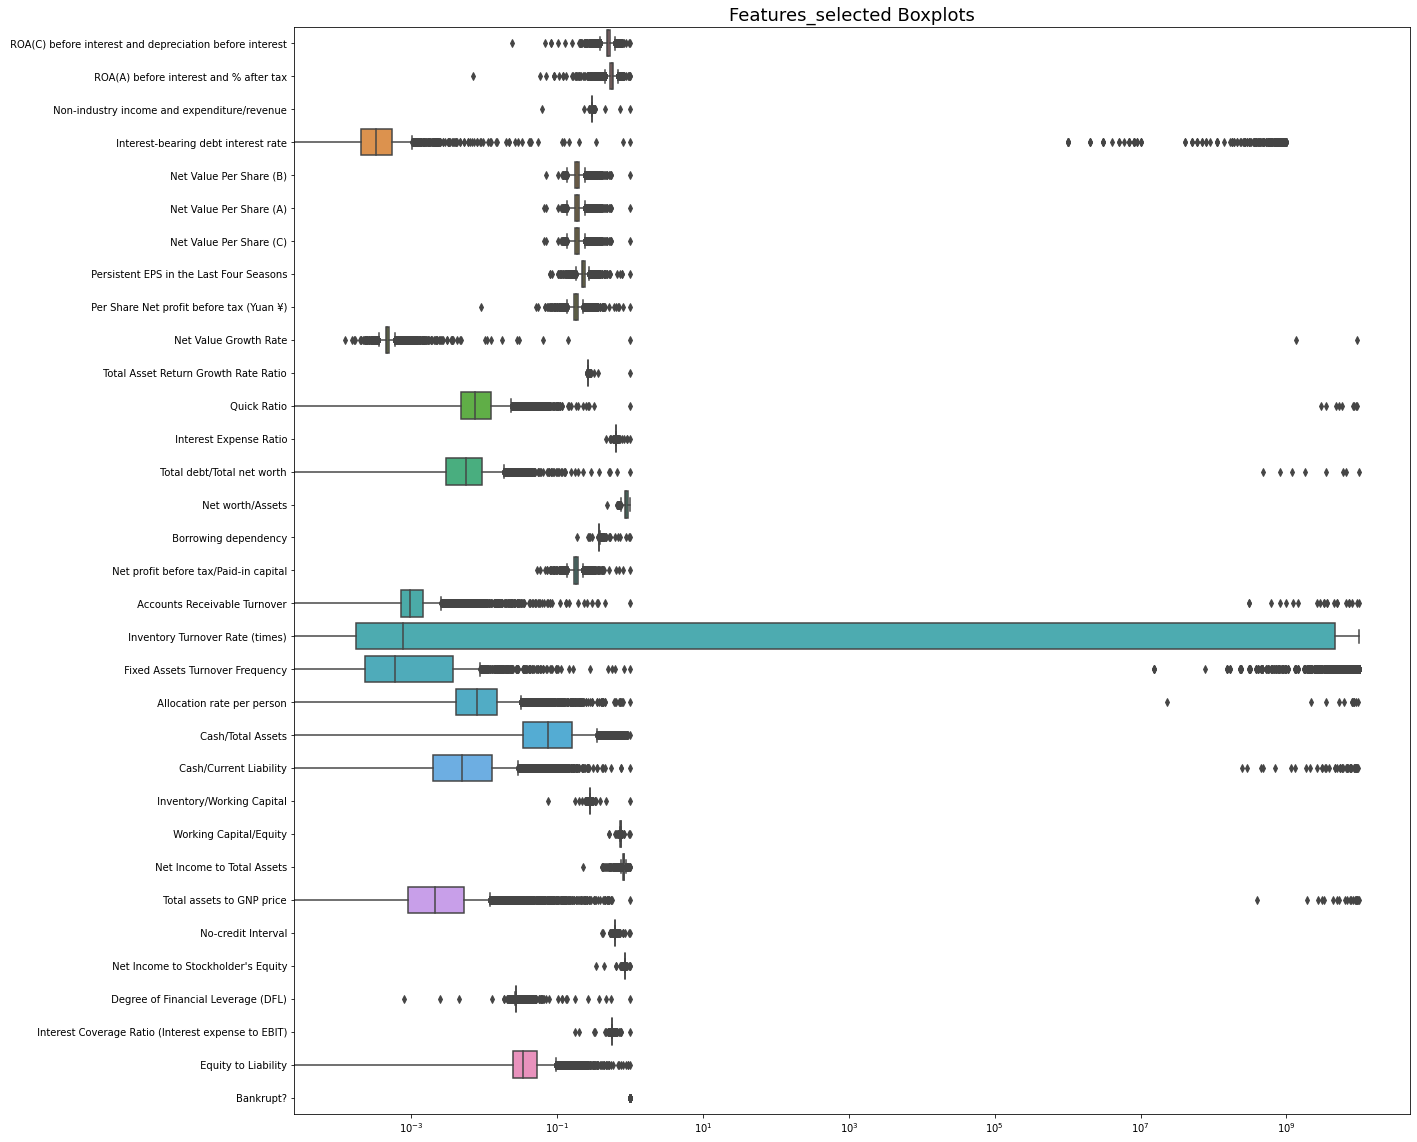

In [ ]:
# Visulize outliers using boxplots
plt.figure(figsize = (20,20))
ax =sns.boxplot(data= rfecv_df, orient="h")
ax.set_title('Features_selected Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

This dataset contains too many outliers. 

## D) Predicting Bankruptcy

Since this is a binary classification problem, we are more interested by predicting the positive value namely the Bankrupt category = 1. The positive category is our minority class and this will pose a real challenge for machine learning models. The best way to measure the performance of our models in this case is by computing the f1 score which is the average of our recall and precision. Recall or also called sensitivity is the metric that gives us true positive rate which is the correctly classified positives out of all possible positives, while precision will tell us what is the proportion of correctly classified positive out of all predicted positives. Recall has as main goal to minimize false negatives while precision aims to minimize false positives. 

### a) Testing models

I'll first use the features selected by the RFECV to test the models on. Later on, I'll use the SelectKbest features' selection.

In [13]:
# Evaluation function 
def evaluation(model):
  model.fit(X_train, y_train)
  ypred = model.predict(X_test)
  print(confusion_matrix(y_test, ypred))
  print(classification_report(y_test, ypred))
    
  N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=5, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
  plt.figure(figsize=(12, 8))
  plt.plot(N, train_score.mean(axis=1), label='train score')
  plt.plot(N, val_score.mean(axis=1), label='validation score')
  plt.legend()

In [15]:
# Set X and y 
X = rfecv_df.iloc[:, :-1].values
y = rfecv_df.iloc[:, -1].values
# Set training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
# Set models with default params
RandomForest = RandomForestClassifier(random_state=0)
AdaBoost = AdaBoostClassifier(random_state=0)
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
# Set dictionary of models
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'KNN': KNN
                  
                 }

RandomForest
[[1641    6]
 [  45   13]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1647
           1       0.68      0.22      0.34        58

    accuracy                           0.97      1705
   macro avg       0.83      0.61      0.66      1705
weighted avg       0.96      0.97      0.96      1705

AdaBoost
[[1629   18]
 [  39   19]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1647
           1       0.51      0.33      0.40        58

    accuracy                           0.97      1705
   macro avg       0.75      0.66      0.69      1705
weighted avg       0.96      0.97      0.96      1705

KNN
[[1642    5]
 [  47   11]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1647
           1       0.69      0.19      0.30        58

    accuracy                           0.97      1705
   macro avg       0.

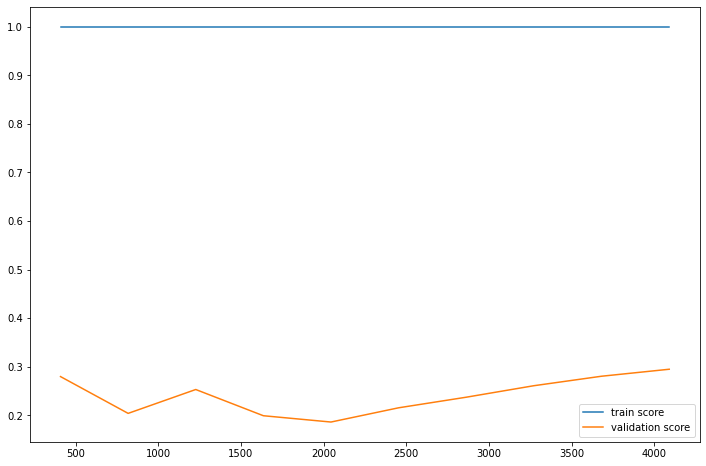

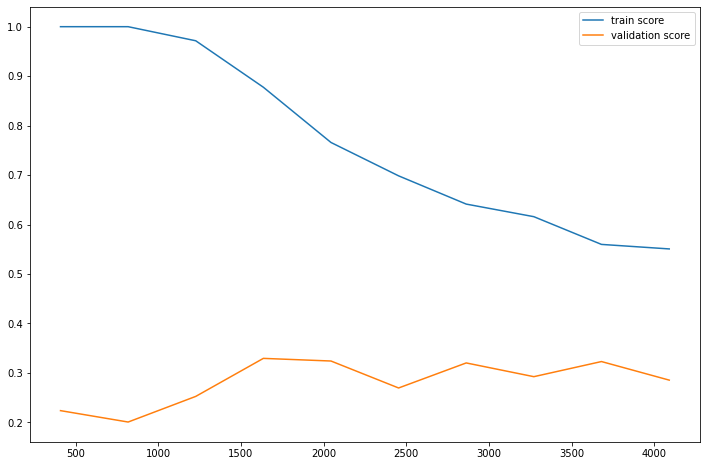

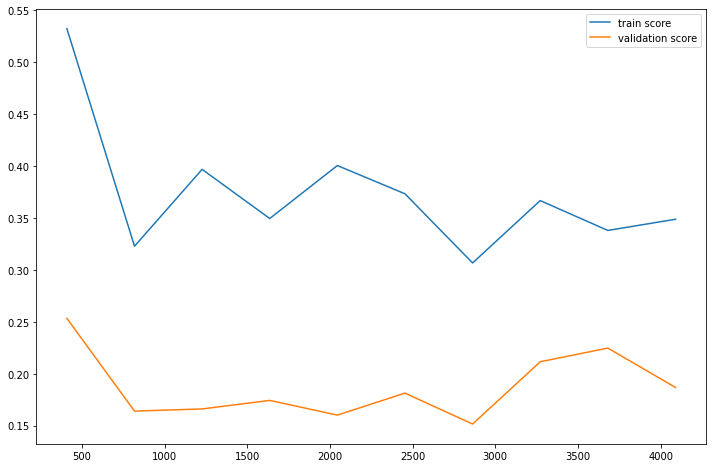

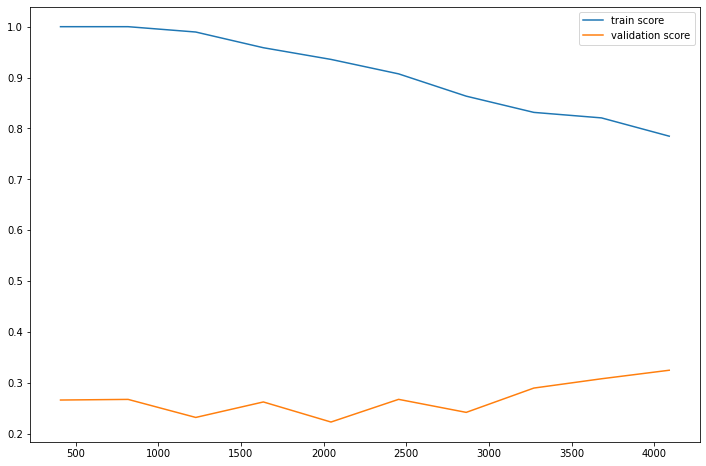

In [ ]:
# Evaluate models
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

RFC and AdaBoost seem to yield highest f1 score. We'll continue using these models. But since the data is very imbalanced, the model will obviously be biased towards the majority class. We'll use SMOTE in order to rebalance the data. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

### b) SMOTE & RandomForestClassifier

We can use SMOTE to either oversample the minority class or undersample the majority class in order to rebalance the data. Other strategies of rebalancing the data are possible for example using both oversampling and undersampling at the same time. In our approach we'll test both the oversampling and over/undersampling strategy. Since machine learning models are automatically biased towards the majority class, using SMOTE will hopefully make the training process of the model more reliable.

In [ ]:
# USING OVERSAMPLING ONLY
kf = RepeatedStratifiedKFold(n_splits=5)
# Set empty lists to store key metrics
accuracy = []
f1 = []
recall =[]
precision = []
# Loop over kfolds
for kf, (train_index, test_index) in enumerate(kf.split(X, y), 1):
    X_train = X[train_index, :]
    y_train = y[train_index]  
    X_test = X[test_index, :]
    y_test = y[test_index]  
    # Set pipeline where SMOTE with oversampling is applied before model fitting
    model = make_pipeline(SMOTE() ,RandomForestClassifier(random_state=0))
    # Fit model
    model.fit(X_train, y_train)
    # Predict on original test set  
    y_pred = model.predict(X_test)
    # Compute key metrics for target "Bankrupt = 1"
    accuracy.append(model.score(X_test, y_test))
    f1.append(f1_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
# Print key metrics      
print("Mean accuracy:", np.mean(accuracy))
print("Mean f1", np.mean(f1))
print("Mean recall", np.mean(recall))
print("Mean precision", np.mean(precision))

Mean accuracy: 0.9501978450158461
Mean f1 0.428576541032856
Mean recall 0.5786363636363636
Mean precision 0.3419491067919593


We can see that by applying oversampling, the f1 score slightly improve. We sig improved our recall but our precision went down. 

In [ ]:
# SMOTE startegy with both over and undersampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [ ]:
# USING BOTH OVER AND UNDERSAMPLING
kf = RepeatedStratifiedKFold(n_splits=5)
# Set empty lists to store key metrics
accuracy = []
f1 = []
recall =[]
precision = []
# Loop over kfolds
for kf, (train_index, test_index) in enumerate(kf.split(X, y), 1):
    X_train = X[train_index, :]
    y_train = y[train_index]  
    X_test = X[test_index, :]
    y_test = y[test_index]  
    # Set pipeline where SMOTE is applied before model fitting
    model = make_pipeline(over, under ,RandomForestClassifier(random_state=0))
    # Fit model
    model.fit(X_train, y_train)
    # Predict on original test set  
    y_pred = model.predict(X_test)
    # Compute key metrics for target "Bankrupt = 1"
    accuracy.append(model.score(X_test, y_test))
    f1.append(f1_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
# Print key metrics      
print("Mean accuracy:", np.mean(accuracy))
print("Mean f1", np.mean(f1))
print("Mean recall", np.mean(recall))
print("Mean precision", np.mean(precision))

Mean accuracy: 0.9310890888866418
Mean f1 0.4079422550709595
Mean recall 0.7327272727272727
Mean precision 0.28331695140379465


Using both over and undersampling yielded a less greater f1 score but the recall increased sharply.

### c) SMOTE & AdaBoost

In [ ]:
# USING OVERSAMPLING ONLY
kf = RepeatedStratifiedKFold(n_splits=5)
# Set empty lists to store key metrics
accuracy = []
f1 = []
recall =[]
precision = []
# Loop over kfolds
for kf, (train_index, test_index) in enumerate(kf.split(X, y), 1):
    X_train = X[train_index, :]
    y_train = y[train_index]  
    X_test = X[test_index, :]
    y_test = y[test_index]  
    # Set pipeline where SMOTE is applied before model fitting
    model = make_pipeline(SMOTE() ,AdaBoostClassifier(random_state=0))
    # Fit model
    model.fit(X_train, y_train)
    # Predict on original test set  
    y_pred = model.predict(X_test)
    # Compute key metrics for target "Bankrupt = 1"
    accuracy.append(model.score(X_test, y_test))
    f1.append(f1_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
# Print key metrics      
print("Mean accuracy:", np.mean(accuracy))
print("Mean f1", np.mean(f1))
print("Mean recall", np.mean(recall))
print("Mean precision", np.mean(precision))

Mean accuracy: 0.8961869194871585
Mean f1 0.3159242260456054
Mean recall 0.7413636363636364
Mean precision 0.20099271938680352


Adaboost yielded lower f1 score, although the recall drastically improved. This model will have a quite high sensitivity meaning it will correctly detect True Positives namely companies that will go bankrupt but will also give high proportion of False Positives (around 80%). 

In [ ]:
# # USING BOTH OVER AND UNDERSAMPLING
kf = RepeatedStratifiedKFold(n_splits=5)
# Set empty lists to store key metrics
accuracy = []
f1 = []
recall =[]
precision = []
# Loop over kfolds
for kf, (train_index, test_index) in enumerate(kf.split(X, y), 1):
    X_train = X[train_index, :]
    y_train = y[train_index]  
    X_test = X[test_index, :]
    y_test = y[test_index]  
    # Set pipeline where SMOTE is applied before model fitting
    model = make_pipeline(over, under ,AdaBoostClassifier(random_state=0))
    # Fit model
    model.fit(X_train, y_train)
    # Predict on original test set  
    y_pred = model.predict(X_test)
    # Compute key metrics for target "Bankrupt = 1"
    accuracy.append(model.score(X_test, y_test))
    f1.append(f1_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
# Print key metrics      
print("Mean accuracy:", np.mean(accuracy))
print("Mean f1", np.mean(f1))
print("Mean recall", np.mean(recall))
print("Mean precision", np.mean(precision))

Mean accuracy: 0.9101187435857162
Mean f1 0.33915160315156556
Mean recall 0.7127272727272728
Mean precision 0.22297745509403583


Adaboost seem to yield slightly better f1 score with this SMOTE startegy. 

### Conclusions:

RandomForestClasifier + Oversampling gave us the highest f1 score of about 43% with 58% Recall and 34% Precision. We'll keep using this model.

### d) Feature engineering

In order to increase the accuracy of our model, let's try to do some feature engineering. I'll try to compute a benchmark (High Financial ratios from stable companies) and then compare it to other ratios in the dataset.

In [ ]:
# Extreme positive values before cleaning
rfecv_df.max()[rfecv_df.max() > 1]

 Interest-bearing debt interest rate    9.900000e+08
 Net Value Growth Rate                  9.330000e+09
 Quick Ratio                            9.230000e+09
 Total debt/Total net worth             9.940000e+09
 Accounts Receivable Turnover           9.740000e+09
 Inventory Turnover Rate (times)        9.990000e+09
 Fixed Assets Turnover Frequency        9.990000e+09
 Allocation rate per person             9.570000e+09
 Cash/Current Liability                 9.650000e+09
 Total assets to GNP price              9.820000e+09
dtype: float64

Most values ranges between 0 and 1. But we have some large positive values up to 10^9. We'll do some preprocessing for these values.

In [23]:
# Some preprocessing
# Seperate dfs and replace large values with median of its respective group
bank_df_clean = df[df['Bankrupt?']==1].apply(lambda x: np.where(x > 1, np.median(x), x))
bank_df_clean[" Inventory Turnover Rate (times)"] = bank_df_clean[" Inventory Turnover Rate (times)"].apply(lambda x: np.where(x > 1, 1, x)) # Since it has a large median we replace by max value 1
not_bank_df_clean = df[df['Bankrupt?']==0].apply(lambda x: np.where(x > 1, np.median(x), x))
# Concat dfs
df_clean = pd.concat([bank_df_clean,not_bank_df_clean]).sort_index()

In [24]:
# Check again (We still have some extreme values since their median is also very large), we'll just keep them anyway
df_clean.max()[df_clean.max() > 1]

 Research and development expense rate    5.430000e+08
 Total Asset Growth Rate                  6.440000e+09
 Cash Turnover Rate                       1.305000e+09
dtype: float64

In [33]:
# Feature engineering
# Add mean ROA and mean NVP
df_clean["Mean_ROA"] = (df_clean[" ROA(C) before interest and depreciation before interest"] + df_clean[" ROA(A) before interest and % after tax"]) / 2
df_clean["Mean_NPV"] = (df_clean[" Net Value Per Share (B)"] + df_clean[" Net Value Per Share (C)"]) / 2
# ROA + ROC measure return on Assets, higher the return less likely the company will go bankrupt
# Calculate percentiles of debt + profit ratios for stable companies
pct_roa_stable = np.percentile(df_clean[' ROA(A) before interest and % after tax'][df_clean['Bankrupt?'] == 0], 75)
pct_roc_stable = np.percentile(df_clean[' ROA(C) before interest and depreciation before interest'][df_clean['Bankrupt?'] == 0], 75)
# HIGH NPV in Stable Companies
pct_npv_stable = np.percentile(df_clean[' Net Value Per Share (B)'][df_clean['Bankrupt?'] == 0], 75)
pct_npv_stable = np.percentile(df_clean[' Net Value Per Share (A)'][df_clean['Bankrupt?'] == 0], 75)
pct_npv_stable = np.percentile(df_clean[' Net Value Per Share (C)'][df_clean['Bankrupt?'] == 0], 75)

In [34]:
# Add HIGH ROA features, if true then the company has higher than avg ROA
df_clean['High_ROA?'] = df_clean[' ROA(A) before interest and % after tax'].apply(lambda x: 1 if x > pct_roa_stable else 0)
df_clean['High_ROC?'] = df_clean[' ROA(C) before interest and depreciation before interest'].apply(lambda x: 1 if x > pct_roc_stable else 0)
# Add Feature that outputs 1 if company has no High ROA or ROC
df_clean['ROC_flag?'] = df_clean[['High_ROA?', 'High_ROC?']].sum(axis=1) < 1
# HIGH NPV features, NPV tells you how valued the company is, higher better
df_clean['High_NPV_1?'] = df_clean[' Net Value Per Share (A)'].apply(lambda x: 1 if x > pct_npv_stable else 0)
df_clean['High_NPV_2?'] = df_clean[' Net Value Per Share (B)'].apply(lambda x: 1 if x > pct_npv_stable else 0)
df_clean['High_NPV_3?'] = df_clean[' Net Value Per Share (C)'].apply(lambda x: 1 if x > pct_npv_stable else 0)
# If a company has only one High NPV then outputs 1
df_clean['NPV_flag?'] = df_clean[['High_NPV_1?', 'High_NPV_2?', 'High_NPV_3?']].sum(axis=1) <= 1


In [35]:
# Set X and y for clean df
X_c = df_clean.drop(['Bankrupt?',' ROA(A) before interest and % after tax', ' ROA(C) before interest and depreciation before interest',
                      ' Net Value Per Share (A)', ' Net Value Per Share (B)', ' Net Value Per Share (C)'
                     ], axis=1) # Drop target plus other features that were engineered 
y_c = df_clean['Bankrupt?'].values
# Set training and testing sets for new df
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, random_state=42)

### e) Retrain Models

I'll retrain my model using this time all features of the dataset + engineered features. I'll execute a selectKbest before model fitting and see if there is improvement in model's performance.

In [37]:
# Retrain using RFC+SMOTE Oversampling with new features added
kf = RepeatedStratifiedKFold(n_splits=5)
accuracy = []
f1 = []
recall =[]
precision = []
for kf, (train_index, test_index) in enumerate(kf.split(X_c, y_c), 1):
    X_train_c = X_c.iloc[train_index, :]
    y_train_c = y_c[train_index]  
    X_test_c = X_c.iloc[test_index, :]
    y_test_c = y_c[test_index]  
    # Use Kbest to choose top 30 features 
    model = make_pipeline(SelectKBest(k=30) ,SMOTE() ,RandomForestClassifier(random_state=0))
    model.fit(X_train_c, y_train_c)  
    y_pred = model.predict(X_test_c)
    accuracy.append(model.score(X_test_c, y_test_c))
    f1.append(f1_score(y_test_c, y_pred))
    recall.append(recall_score(y_test_c, y_pred))
    precision.append(precision_score(y_test_c, y_pred))
      
print("Mean accuracy:", np.mean(accuracy))
print("Mean f1", np.mean(f1))
print("Mean recall", np.mean(recall))
print("Mean precision", np.mean(precision))

Mean accuracy: 0.9974776078298906
Mean f1 0.959780290254571
Mean recall 0.9381818181818182
Mean precision 0.983420684509207


Here comes the power of feature engineering ! Adding these simple features and using the selectkbest feature selection has really improved the f1 score (43% without feature engineering vs 96% with feature engineering + Kbest feature selection). SelectKbest seem to output better predictive features than RFECV. 

### f) Model Tuning

Let's verify if we can get a further increase in our f1 score if we choose another number of k features in the select kbest. I'll use this function to do so.

k=5 f1=0.598 sd=(0.099)
k=10 f1=0.670 sd=(0.115)
k=15 f1=0.711 sd=(0.100)
k=20 f1=0.763 sd=(0.104)
k=25 f1=0.936 sd=(0.051)
k=30 f1=0.964 sd=(0.033)
k=35 f1=0.949 sd=(0.039)
k=40 f1=0.961 sd=(0.041)
k=45 f1=0.944 sd=(0.039)
k=50 f1=0.955 sd=(0.039)
k=60 f1=0.958 sd=(0.035)
k=70 f1=0.959 sd=(0.057)
k=80 f1=0.965 sd=(0.038)
k=85 f1=0.970 sd=(0.035)
k=90 f1=0.973 sd=(0.031)
k=99 f1=0.970 sd=(0.030)


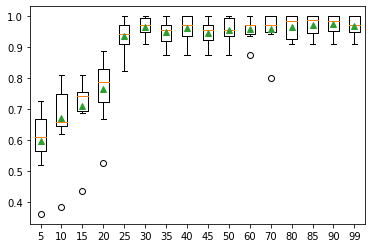

In [56]:
# Look for optimal number of features using kbest and CART model as estimator
n_features = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 85, 90, 99]
# Function_to_get_models
def get_models(n_features):
  models = {}
  for k in n_features:
    # Set model
    model = RandomForestClassifier(random_state=0)
    # Append models to dic
    models[str(k)] = make_pipeline(SelectKBest(f_classif, k=k), SMOTE(), model)
  return models
    
# Function_to_evaluate_models
def evaluate_model(model, X_c, y_c):
  scores = cross_val_score(model, X_c, y_c, scoring='f1', cv=10, n_jobs=-1) 
  return scores

# Get models to evaluate
models = get_models(n_features)

# Create empty list to store results of CVs for each model
results, names = [], []
for name, model in models.items():
  scores = evaluate_model(model, X_train_c, y_train_c)
  results.append(scores)
  names.append(name)
  print('k=%s f1=%.3f sd=(%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

90 Features seem to yield the highest f1 score. If want to train our model faster we can use only 30 features and we loose just a tiny performance.

In [59]:
# TUNE MODEL
cart = make_pipeline(SelectKBest(k=90), SMOTE(), RandomForestClassifier(random_state=0)) 
# Set hyperparameters for AdaBoost
param_grid = {'randomforestclassifier__bootstrap': [False, True],
 'randomforestclassifier__max_depth': [50, None],
 'randomforestclassifier__max_features': ['auto', 'sqrt'],
 'randomforestclassifier__n_estimators': [100, 200, 300],
 'smote__k_neighbors': [5, 7]}

# Startified cv
cv = StratifiedKFold(n_splits=3)
# Set grid                
grid = RandomizedSearchCV(cart, param_grid, scoring='f1', cv=cv, 
                          n_jobs=-1, random_state=42, n_iter=40
                          )
# Fit data
grid.fit(X_train_c, y_train_c)
# Get best_model
best_model = grid.best_estimator_
# Best score
print(grid.best_score_)
# Print best params
print(grid.best_params_)
# Predict on unseen data
y_pred = best_model.predict(X_test_c)
# Classification report
print(classification_report(y_test_c, y_pred))

0.9738086860056848
{'smote__k_neighbors': 7, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__bootstrap': True}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1319
         1.0       1.00      0.95      0.98        44

    accuracy                           1.00      1363
   macro avg       1.00      0.98      0.99      1363
weighted avg       1.00      1.00      1.00      1363



  ## Final Conclusion

RandomForestClassifier trained using feature engineering + SMOTE yields a very good f1 score of around 98%. 